In [1]:
%matplotlib notebook 
%matplotlib inline
# %matplotlib widget

## Imports:

In [2]:
import h5py

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

from matplotlib.ticker import LinearLocator, FormatStrFormatter, FixedLocator

In [6]:
from matplotlib.legend_handler import HandlerLine2D

In [7]:
import pylab

In [8]:
import pandas

In [9]:
import math

## Available h5 data files:

In [10]:
tenFlat_free_Feb = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_5-11Feb_compoundFull.h5'

In [11]:
tenFlat_free_Nov = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_15-21Nov_compoundFull.h5'

In [12]:
tenFlat_free_Mar = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_15-21Mar_compoundFull.h5'

In [13]:
tenFlat_free_Jul = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_17-23Jul_compoundFull.h5'

In [14]:
tenFlat_free_SepOct = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_29Sep-5Oct_compoundFull.h5'

In [15]:
tenFlatHIns_unconstrained_Feb = '../../data/h5_from_espr/h_ins/exergyResults_tenFlat_hIns_5-11Feb_compoundFull_unconstrainedControl.h5'

In [16]:
tenFlatHIns_basicControl_Feb = '../../data/h5_from_espr/h_ins/exergyResults_tenFlat_hIns_5-11Feb_compoundFull_BasicControl.h5'

### List of all datasets:

In [17]:
file_list = [tenFlat_free_Feb, tenFlat_free_Nov, tenFlat_free_Mar, tenFlat_free_Jul, tenFlat_free_SepOct, tenFlatHIns_unconstrained_Feb, tenFlatHIns_basicControl_Feb]

In [18]:
hvac_file_list = [tenFlatHIns_unconstrained_Feb, tenFlatHIns_basicControl_Feb]

### Define a function used to scan the file stucture:

In [19]:
from __future__ import print_function

def scan_hdf5(path, recursive=True, tab_step=2):
    def scan_node(g, tabs=0):
        print(' ' * tabs, g.name)
        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                print(' ' * tabs + ' ' * tab_step + ' -', v.name)
            elif isinstance(v, h5py.Group) and recursive:
                scan_node(v, tabs=tabs + tab_step)
    with h5py.File(path, 'r') as f:
        scan_node(f)

In [20]:
scan_hdf5(tenFlatHIns_unconstrained_Feb)

 /
   /01
     - /01/layer_values
     - /01/temperatures
   /02
     - /02/layer_values
     - /02/temperatures
   /03
     - /03/layer_values
     - /03/temperatures
   /04
     - /04/layer_values
     - /04/temperatures
   /05
     - /05/layer_values
     - /05/temperatures


### layer_values: 
contains the properties of each construction layer (or volume of air) and the average layer temperature; 

### temperatures:
contains the temperature (in deg C) of each node (each layer has 3 nodes, the boundary nodes are shared between adjacent layers)

## Open the desired hdf5 file and call it f
### (names and paths above, copy the desidered name in the next function) 

In [21]:
f = h5py.File(tenFlatHIns_unconstrained_Feb,'r')

### check the structure of the file by listing its keys:

In [22]:
list(f.keys())

['01', '02', '03', '04', '05']

In [23]:
list(f['/01'].keys())

['layer_values', 'temperatures']

In [24]:
# not sure how I can get the structure of the compound data inside... find out!
# list(f['/01/layer_values'].fields)

### Define a more convenient name for the relevant datasets:

In [25]:
zone01=f['/01']

In [26]:
zone02=f['/02']

In [27]:
zone03=f['/03']

In [28]:
layers_01=f['/01/layer_values']

In [29]:
temperatures_01=f['/01/temperatures']

In [30]:
layers_02=f['/02/layer_values']

In [31]:
temperatures_02=f['/02/temperatures']

In [32]:
layers_03=f['/03/layer_values']

In [33]:
temperatures_03=f['/03/temperatures']

### Check if possible to retrieve a value, for instance the conductivity k of layer 1, surface 1, zone 01 at timestep 1 

#### Format: layers_zone(layer,surface,timestep)

In [34]:
#indexes of zone dataset: layer,surface,timestep
layers_01[1,1,1]['k']

0.84

# ZONE: number of dataset

In [35]:
zone_dataset = layers_01

## CALCULATE DEAD STATE AT EACH TIME INCLUDING ONLY 10CM OF INNER LAYERS

### 1. for a specific timestep (hour) of a dataset:

In [36]:
def calculate_dead_T(time,dataset):
    dead_T = 0.0
    dead_T_numerator = 0.0
    dead_T_denominator = 0.0
    for surf in range(0,dataset.shape[1]-2):
        total_thickness_included = 0
        for layer in range(0,dataset.shape[0]):
            if total_thickness_included >= 0.10000:
                break
            if dataset[layer,surf,time]['k'] < 0.06:
                break
            if (total_thickness_included + dataset[layer][surf][time]['th']) <= 0.10000:
                total_thickness_included += dataset[layer][surf][time]['th']
                # and add the contribution with full thickness
                dead_T_numerator += dataset[layer][surf][time]['d']*dataset[layer][surf][time]['th']*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']*dataset[layer][surf][time]['T']
                dead_T_denominator += dataset[layer][surf][time]['d']*dataset[layer][surf][time]['th']*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']
            else:
                partial_layer_th = 0.10000 - total_thickness_included
                total_thickness_included = 0.10000
                # and add the contribution with partial thickness
                dead_T_numerator += dataset[layer][surf][time]['d']*partial_layer_th*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']*dataset[layer][surf][time]['T']
                dead_T_denominator += dataset[layer][surf][time]['d']*partial_layer_th*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']

    dead_T = dead_T_numerator/dead_T_denominator
    return dead_T   
        

### for example, at timestep 6 of the selected zone:

In [37]:
calculate_dead_T(6,zone_dataset)

20.385390924063774

### 2. function of time:

In [38]:
def calculate_dead_T_array(dataset):
    dead_T_array = np.zeros(shape=dataset.shape[2],dtype=float)
    for time in range(0,dead_T_array.size):
        dead_T_array[time] = calculate_dead_T(time,dataset)
    return dead_T_array
        

In [39]:
deadTs = calculate_dead_T_array(zone_dataset)

In [40]:
deadTs

array([20.00394567, 20.54795493, 20.47122461, 20.40408721, 20.35632157,
       20.35055247, 20.38539092, 20.43067382, 20.46188898, 20.48154435,
       20.5004818 , 20.51375263, 20.50775448, 20.48499382, 20.4564505 ,
       20.41842772, 20.36152806, 20.28624219, 20.21106504, 20.14478942,
       20.07542902, 19.99838614, 19.92750352, 19.8837369 , 20.62401465,
       19.90575251, 19.98165929, 20.09647519, 20.24447309, 20.41915222,
       20.61286852, 20.8192134 , 21.02665782, 21.20334301, 21.32128255,
       21.39515881, 21.44341559, 21.46533476, 21.46040117, 21.43149522,
       21.38033143, 21.30961198, 21.23457737, 21.16707707, 21.095943  ,
       21.01269938, 20.92896781, 20.85298258, 19.87487261, 20.6939306 ,
       20.60404927, 20.51665266, 20.42846663, 20.34585191, 20.29001529,
       20.27012455, 20.28356018, 20.31774369, 20.33419838, 20.30502216,
       20.25690289, 20.21018337, 20.15219102, 20.0799003 , 20.00424601,
       19.93125738, 19.85161552, 19.77280936, 19.70885592, 19.64

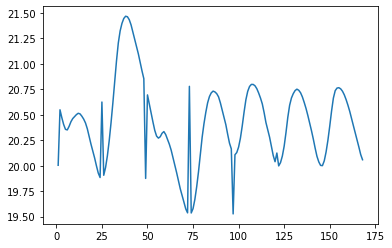

In [41]:
x_coordinate = [ i+1 for i in range(len(deadTs)) ]
plt.plot(x_coordinate,deadTs)
plt.savefig('../../results/myplot.png')

## Produce figures for all the zones in one file

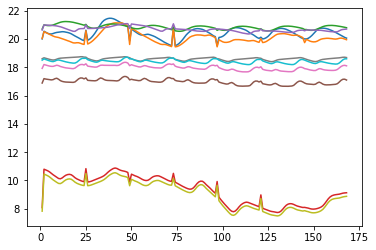

In [46]:
file_num = 0
for file in hvac_file_list:
    
    file_num = file_num + 1
    f = h5py.File(file,'r')
    
    zone_01=f['/01/layer_values'] # bedroom
    zone_02=f['/02/layer_values'] # living room
    zone_03=f['/03/layer_values'] # bathroom
    zone_04=f['/04/layer_values'] # loft
    zone_05=f['/05/layer_values'] # hall
    zone_datasets = [zone_01,zone_02,zone_03,zone_04,zone_05]
    
    z = 0
    for zone_dataset in zone_datasets:
        z = z+1
        deadTs = calculate_dead_T_array(zone_dataset)
        
        x_coordinate = [ i+1 for i in range(len(deadTs)) ]
        plt.plot(x_coordinate,deadTs)
        plt.savefig('../../results/'+str(file_num)+'_'+str(z)+'.png')

In [45]:
file

'../../data/h5_from_espr/h_ins/exergyResults_tenFlat_hIns_5-11Feb_compoundFull_unconstrainedControl.h5'